#### Load necessary packages

In [1]:
import os
import sys
sys.path.insert(0,'../../mocsy')

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from tqdm import tqdm
import pickle 
import random
import matplotlib.pyplot as plt
from scipy import stats

import mocsy
from mocsy import mvars
from mocsy import mrhoinsitu
from mocsy import mrho

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Training data

#### Read in the observational data

In [4]:
print("for tos, use the ESA CCI and C3S product until October 2022, then Armor3D for November and December")
print("for siconc, use the ESA CCI and C3S product until October 2022, then METOFFICE Ostia for November and December")
print("for chlos, use the climatological mean value before September 1997")
print("for co2, use a global representative value, given by the annual average measurement from Manua Loa, Hawaii")
ds_cci = xr.open_dataset("../data/ESACCI_and_C3S-GLO-SST-L4-REP-OBS-SST_multi-vars_1x1grid_1982-01-01-2022-10-31_monmean.nc"
                    ).sel(time=slice('1993-01-01', '2022-10-31'))
ds_ostia = xr.open_dataset("../data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_multi-vars_1x1grid_2022-11-01-2022-12-31_monmean.nc")
ds_armor = xr.open_dataset("../data/dataset-armor-3d-rep-monthly_multi-vars_1x1grid_coarsened_0.00m_1993-01-01-2022-12-01.nc")
ds_ssh = xr.open_dataset(
     "../data/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_adt_1x1grid_coarsened_1993-01-01-2022-12-31_monmean.nc")
ds_globcol = xr.open_dataset("../data/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_multi-vars_1x1grid_1997-09-01-2022-12-01.nc")
ds_globcol_clim = xr.open_dataset(
    "../data/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_multi-vars_1x1grid_1997-09-01-2022-12-01_ymonmean.nc")

df_co2 = pd.read_csv("../data/monthly_in_situ_co2_mlo_no_header.csv")
ds_era5 = xr.open_dataset("../data/era5_winds_1993_2022_1x1grid.nc")
ds_socat = xr.open_dataset("../data/SOCATv2023_tracks_gridded_monthly.nc").sel(tmnth=slice('1993-01-01', '2022-12-31'))

seamask = xr.open_dataset("../data/RECCAP2_region_masks_all_v20221025.nc").seamask
seamask_rolled = np.repeat(np.roll(seamask.values, shift=-180, axis=1)[np.newaxis, :, :], 360, axis=0)

for tos, use the ESA CCI and C3S product until October 2022, then Armor3D for November and December
for siconc, use the ESA CCI and C3S product until October 2022, then METOFFICE Ostia for November and December
for chlos, use the climatological mean value before September 1997
for co2, use a global representative value, given by the annual average measurement from Manua Loa, Hawaii


In [5]:
data = {}

data["tos"] = np.concatenate([ds_cci.analysed_sst.values - 273.15, # ESA CCI and C3S is in Kelvin units
                      ds_armor.to.squeeze().values[-2:, :, :]], axis=0)

data["tos"][seamask_rolled == 0] = np.nan

data["siconc"] = np.concatenate([ds_cci.sea_ice_fraction.values,
                         ds_ostia.sea_ice_fraction.values], axis=0) * 100
# to have concentration in range 0 100, as in models
data["siconc"][seamask_rolled == 0] = np.nan


data["sos"] = ds_armor.so.squeeze().values
#Remove samples with sos < 10, since these were also removed during training of CMIP6 base model"
data["sos"][data["sos"] < 10] = np.nan
data["sos"][seamask_rolled == 0] = np.nan

data["mlotst"] = ds_armor.mlotst.squeeze().values
data["mlotst"][seamask_rolled == 0] = np.nan

data["zos"] = ds_ssh.adt.squeeze().values
data["zos"][seamask_rolled == 0] = np.nan

data["chlos"] = np.concatenate([np.concatenate([ds_globcol_clim.CHL.values for i in range(5)],
                                                  axis=0)[:-4, :, :], ds_globcol.CHL.values], axis=0) * 1e-6
# to go from mg m-3 to kg m-3 
#data["chlos"][np.logical_and(np.isnan(data["chlos"]), np.isfinite(data["tos"]))] = 0
data["chlos"][seamask_rolled == 0] = np.nan

df_co2_yearmean = df_co2[['  Yr', '     CO2']].groupby('  Yr').mean()
co2_scalar = df_co2_yearmean.loc[1993:2022]['     CO2'].values
data["co2"] = np.concatenate([co2_year * np.ones((12, 180, 360)) for co2_year in co2_scalar], axis=0)

data["uas"] = ds_era5.u10.values
data["vas"] = ds_era5.v10.values

data["fco2"] = ds_socat.fco2_ave_weighted.values

In [6]:
data["lat"] = np.repeat(np.repeat(np.arange(-89.5, 90)[np.newaxis, :],
                         360, axis=0)[:, :, np.newaxis], 360, axis=2)

data["lon"] = np.repeat(np.repeat(np.arange(-179.5, 180)[np.newaxis, :],
                         180, axis=0)[np.newaxis, :, :], 360, axis=0)
data["mon"] = np.repeat(np.repeat(np.array([i % 12 for i in range(360)])[:, np.newaxis],
                          180, axis=1)[:, :, np.newaxis], 360, axis=2)

In [7]:
predictors = ["tos", "siconc", "sos", "mlotst", "zos", "chlos", "co2",
              "uas", "vas", "lat", "lon", "mon"]
for predictor in predictors:
    print("Number of non-nan grid cells for {}: {}". format(
        predictor, np.sum(np.isfinite(data[predictor]))
    ))

Number of non-nan grid cells for tos: 15058446
Number of non-nan grid cells for siconc: 15058440
Number of non-nan grid cells for sos: 15053204
Number of non-nan grid cells for mlotst: 14983581
Number of non-nan grid cells for zos: 13209876
Number of non-nan grid cells for chlos: 12450247
Number of non-nan grid cells for co2: 23328000
Number of non-nan grid cells for uas: 23328000
Number of non-nan grid cells for vas: 23328000
Number of non-nan grid cells for lat: 23328000
Number of non-nan grid cells for lon: 23328000
Number of non-nan grid cells for mon: 23328000


In [8]:
for predictor in predictors:
    print("Minimum and maximum for {}: {:.2e}, {:.2e}". format(
        predictor, np.nanmin(data[predictor]), np.nanmax(data[predictor])
    ))

Minimum and maximum for tos: -2.11e+00, 3.31e+01
Minimum and maximum for siconc: 0.00e+00, 1.00e+02
Minimum and maximum for sos: 1.00e+01, 3.98e+01
Minimum and maximum for mlotst: 1.01e+01, 2.14e+03
Minimum and maximum for zos: -1.57e+00, 2.20e+00
Minimum and maximum for chlos: 1.06e-08, 4.94e-05
Minimum and maximum for co2: 3.57e+02, 4.18e+02
Minimum and maximum for uas: -1.75e+01, 1.42e+01
Minimum and maximum for vas: -1.58e+01, 2.01e+01
Minimum and maximum for lat: -8.95e+01, 8.95e+01
Minimum and maximum for lon: -1.80e+02, 1.80e+02
Minimum and maximum for mon: 0.00e+00, 1.10e+01


In [9]:
print("Number of non-nan grid cells for fCO2: {}". format(
    np.sum(np.isfinite(data["fco2"]))
    ))

Number of non-nan grid cells for fCO2: 341467


In [10]:
print("Minimum and maximum for fCO2: {:.2e}, {:.2e}". format(
    np.nanmin(data["fco2"]), np.nanmax(data["fco2"])
))

Minimum and maximum for fCO2: 4.45e+01, 4.31e+03


#### Creation of training data

In [11]:
print("Number of SOCAT samples: {}".format(np.sum(np.isfinite(data["fco2"]))))
# check how many grid cells have non-nan values in socat fco2 and all predictor fields
# (some predictors left out because they have no missing values)
is_socat_training_sample = np.isfinite(data["fco2"] * data["siconc"] * data["tos"] * data["sos"]
                                       * data["mlotst"] * data["zos"] * data["chlos"])
print("Number of SOCAT samples where all predictors available: {} ({:.1f} %)".format(
    np.sum(is_socat_training_sample),
    100 * np.sum(is_socat_training_sample) / np.sum(np.isfinite(data["fco2"]))))

data_socat = {}
for key in ["fco2"] + predictors:
    data_socat[key] = data[key][is_socat_training_sample]

Number of SOCAT samples: 341467
Number of SOCAT samples where all predictors available: 311440 (91.2 %)


# Preprocessing of data for training

#### Transform mon to mon_sin and mon_cos

In [12]:
data_socat["mon_sin"] = np.sin(data_socat["mon"] / 12 * 2 * np.pi)
data_socat["mon_cos"] = np.cos(data_socat["mon"] / 12 * 2 * np.pi)
del data_socat["mon"]

#### Transform lat and lon

Following Gade et al., 2010: A Non-singular Horizontal Position Representation

In [13]:
data_socat["nvector1"] = np.sin(data_socat["lat"] / 360 * 2 * np.pi)
data_socat["nvector2"] = np.sin(data_socat["lon"] / 360 * 2 * np.pi)\
    * np.cos(data_socat["lat"] / 360 * 2 * np.pi)
data_socat["nvector3"] = - np.cos(data_socat["lon"] / 360 * 2 * np.pi)\
    * np.cos(data_socat["lat"] / 360 * 2 * np.pi)
del data_socat["lon"]
del data_socat["lat"]

#### Log-transform mlotst and chlos

In [14]:
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

In [15]:
print("mlotst statistic: ",
      stats.kstest(normalize(data_socat["mlotst"]), stats.norm.cdf)[0])
print("mlotst statistic with log transform: ",
      stats.kstest(normalize(np.log(data_socat["mlotst"])), stats.norm.cdf)[0])

mlotst statistic:  0.23653021181947087
mlotst statistic with log transform:  0.05216682639068482


In [16]:
print("mlotst statistic: ",
      stats.kstest(normalize(data_socat["chlos"]), stats.norm.cdf)[0])
print("mlotst statistic with log transform: ",
      stats.kstest(normalize(np.log(data_socat["chlos"])), stats.norm.cdf)[0])

mlotst statistic:  0.28406905399619975
mlotst statistic with log transform:  0.04376417813484801


Text(0.5, 1.0, 'mlotst')

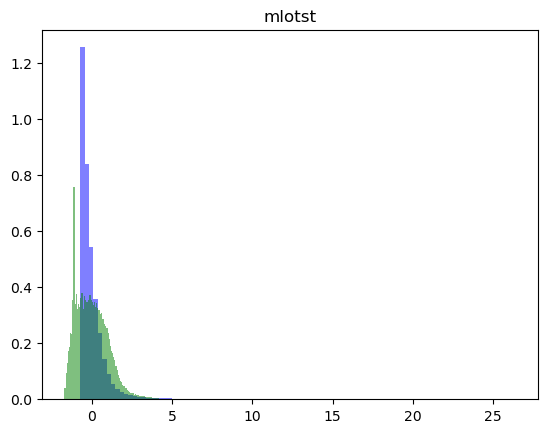

In [17]:
plt.hist(normalize(data_socat["mlotst"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(data_socat["mlotst"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("mlotst")

Text(0.5, 1.0, 'chlos')

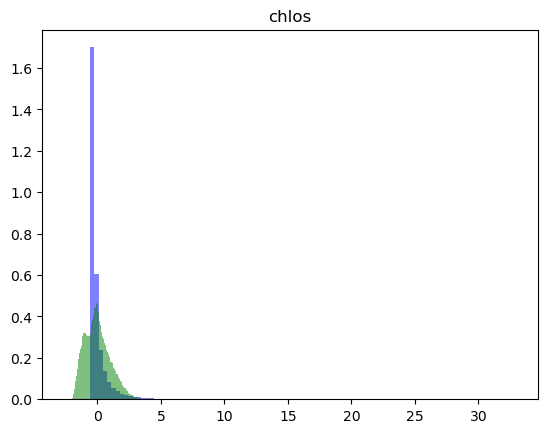

In [18]:
plt.hist(normalize(data_socat["chlos"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(data_socat["chlos"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("chlos")

In [19]:
data_socat["mlotst"] = np.log(data_socat["mlotst"])
data_socat["chlos"] = np.log(data_socat["chlos"])

####  Split into training and validation sets

In [20]:
np.random.seed(0)
random.seed(0)
train_valid_split = 0.833 
# As before, have 5/6 as training and 1/6 as validation data
random_indices = np.arange(len(data_socat["tos"]), dtype=int)

random.shuffle(random_indices)

ntrain_socat = int(len(data_socat["tos"]) * train_valid_split)
train_socat = {key: data_socat[key][random_indices][:ntrain_socat]
               for key in data_socat}
valid_socat = {key: data_socat[key][random_indices][ntrain_socat:]
               for key in data_socat}

#### normalize data and convert into feature and label arrays

In [21]:
feature_keys = ["tos", "sos", "mlotst", "zos", "chlos", "siconc", "uas", "vas",
                "co2", "mon_sin", "mon_cos", "nvector1", "nvector2", "nvector3"]

# Processing the socat data
train_features = np.concatenate([(
    train_socat[key][:, np.newaxis] - np.mean(train_socat[key], keepdims=True)
) / np.std(train_socat[key], keepdims=True) for key in feature_keys], axis=1)

valid_features = np.concatenate([(
    valid_socat[key][:, np.newaxis] - np.mean(train_socat[key], keepdims=True)
) / np.std(train_socat[key], keepdims=True) for key in feature_keys], axis=1)

train_labels = train_socat["fco2"] # maybe add [:, np.newaxis]

valid_labels = valid_socat["fco2"] # maybe add [:, np.newaxis]

In [22]:
print("Check shapes of matrices.")
print(train_features.shape)
print(valid_features.shape)
print(train_labels.shape)
print(valid_labels.shape)

Check shapes of matrices.
(259429, 14)
(52011, 14)
(259429,)
(52011,)


In [23]:
print("Check normalization of features.")
print(np.mean(train_features, axis=0))
print(np.std(train_features, axis=0))
print(np.mean(valid_features, axis=0))
print(np.std(valid_features, axis=0))

Check normalization of features.
[-1.98091549e-07 -1.18313885e-06 -2.34415517e-07 -8.34093408e-17
 -1.71039162e-07  3.77543214e-09  1.61390935e-10  5.67887181e-09
 -2.50701440e-15  1.39513491e-15  8.55629498e-16  1.06597741e-17
 -1.62730916e-16 -3.55865018e-17]
[1.00000007 0.99999996 1.00000001 1.         1.00000012 0.99999994
 0.99999993 0.99999989 1.         1.         1.         1.
 1.         1.        ]
[ 0.00243286  0.00013972 -0.00231412 -0.00164163 -0.0040474  -0.00014885
 -0.00412211 -0.0069778  -0.00411415 -0.00914038  0.00381481  0.00130063
 -0.00261278 -0.00210639]
[1.00407728 0.99088764 0.99790476 1.00104361 0.99878954 0.9961336
 1.00271917 0.99543085 1.00098252 0.99966496 1.00026701 0.99795842
 1.00258622 0.99966814]


# Define neural network and training procedure

In [24]:
class simple_MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.device = torch.device("cuda")
        self.linear1 = nn.Linear(input_size, hidden_size, device=self.device)
        self.linear2 = nn.Linear(hidden_size, hidden_size, device=self.device)
        self.linear3 = nn.Linear(hidden_size, hidden_size, device=self.device)
        self.linear4 = nn.Linear(hidden_size, 1, device=self.device)
    
    def forward(self, x):
        x = x.to(self.device)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear2(x))
        x = F.elu(self.linear3(x))
        x = F.elu(self.linear4(x))
        
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = '../models'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [25]:
def training_dataloader(features, labels, batch_size):
    ntrain = len(labels)
    nbatch = ntrain // batch_size
    indices = np.arange(ntrain, dtype=int)
    random.shuffle(indices)
    batch_indices = np.split(indices[:nbatch * batch_size], nbatch)
    batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                   torch.from_numpy(np.take(labels, ind, axis=0).astype("float32")).to(torch.device("cuda")))
                   for ind in batch_indices]
    return batch_data

In [26]:
loss_function = nn.MSELoss()

In [27]:
def train_one_epoch(optimizer):
    running_loss = 0. # running loss over all batches in the epoch

    training_data = training_dataloader(train_features,
                                        train_labels,
                                        batch_size)
    
    for batch in training_data:
        features, labels = batch
        optimizer.zero_grad()
        outputs = torch.squeeze(model(features))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().cpu().item()

    ntrain = len(train_labels)
    nbatch = ntrain // batch_size

    return running_loss / nbatch

In [28]:
def calc_gammar(reduction_factor, nepochs):                                                                                                                                                                       
    return reduction_factor**(1 / nepochs)

def train(batch_size, n_epochs, optimizer, scheduler):
    train_stats = {"train_loss":[], "valid_loss":[], "learn_rate":[]}

    pbar = tqdm(range(n_epochs), postfix=f'epoch 0/{n_epochs}')
    
    for epoch in pbar:

        model.train()

        train_loss_epoch = train_one_epoch(optimizer)

        model.eval()
        with torch.no_grad():
            valid_outputs = torch.squeeze(model(
                torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda"))))
            valid_loss_epoch = loss_function(
                valid_outputs, torch.from_numpy(valid_labels).to(torch.device("cuda"))
                                        ).detach().cpu().item()
                
        train_stats["train_loss"].append(train_loss_epoch)
        train_stats["valid_loss"].append(valid_loss_epoch)
        
        lr = scheduler.get_last_lr()[0]
        train_stats["learn_rate"].append(lr)

        scheduler.step()

        pbar.set_postfix({'epoch': f'{epoch+1}/{n_epochs}',
                          'train_loss': f'{train_loss_epoch:.3e}',
                          'valid_loss': f'{valid_loss_epoch:.3e}',
                          'learn_rate': f'{lr:.3e}'}
                        )

    return train_stats

# Training

In [29]:
print("Variance in the SOCAT validation set: {:.2f} muatm2".format(np.var(valid_labels)))

Variance in the SOCAT validation set: 1712.27 muatm2


#### Training a tiny model (hidden layer size: 16)

In [30]:
model = simple_MLP(14, 16)
print(model)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

simple_MLP(
  (linear1): Linear(in_features=14, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
)
Number of trainable parameters in the model: 801


In [31]:
batch_size = 1000
n_epochs = 5_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 2500)

optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats_16 = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [22:13<00:00,  3.75it/s, epoch=5000/5000, train_loss=5.376e+02, valid_loss=4.629e+02, learn_rate=1.001e-05]


Text(0.5, 1.0, 'Training of tiny model')

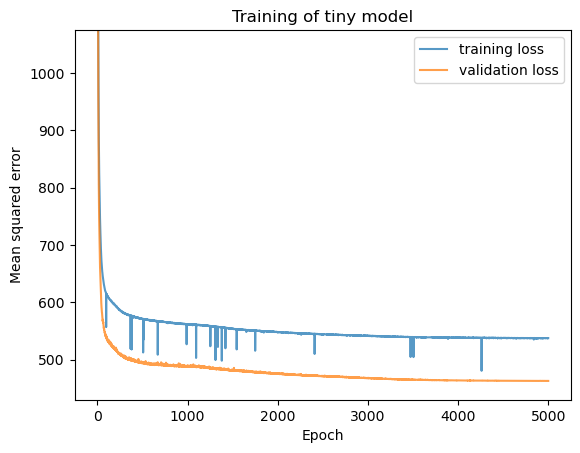

In [32]:
plt.plot(train_stats_16["train_loss"], label="training loss", alpha=0.75)
plt.plot(train_stats_16["valid_loss"], label="validation loss", alpha=0.75)
plt.legend()
plt.ylim([train_stats_16["train_loss"][-1] * 0.8,
          train_stats_16["train_loss"][-1] * 2])
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.title("Training of tiny model")

#### Training a small model (hidden layer size: 36)

In [33]:
model = simple_MLP(14, 36)
print(model)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

simple_MLP(
  (linear1): Linear(in_features=14, out_features=36, bias=True)
  (linear2): Linear(in_features=36, out_features=36, bias=True)
  (linear3): Linear(in_features=36, out_features=36, bias=True)
  (linear4): Linear(in_features=36, out_features=1, bias=True)
)
Number of trainable parameters in the model: 3241


In [34]:
batch_size = 1000
n_epochs = 5_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 2500)

optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats_36 = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [21:30<00:00,  3.87it/s, epoch=5000/5000, train_loss=4.551e+02, valid_loss=3.968e+02, learn_rate=1.001e-05]


Text(0.5, 1.0, 'Training of small model')

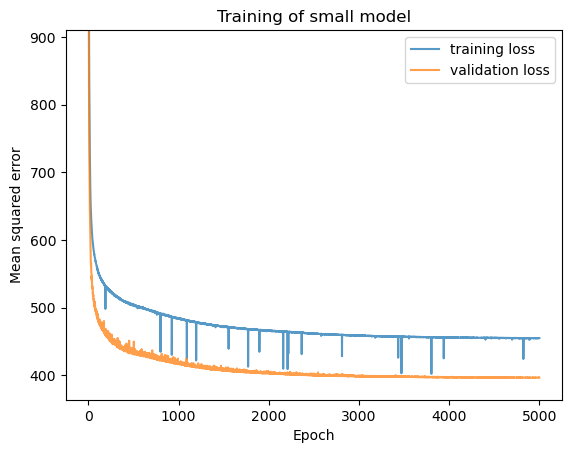

In [35]:
plt.plot(train_stats_36["train_loss"], label="training loss", alpha=0.75)
plt.plot(train_stats_36["valid_loss"], label="validation loss", alpha=0.75)
plt.legend()
plt.ylim([train_stats_36["train_loss"][-1] * 0.8,
          train_stats_36["train_loss"][-1] * 2])
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.title("Training of small model")

#### Training a medium-sized model (hidden layer size: 76)

In [36]:
model = simple_MLP(14, 76)
print(model)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

simple_MLP(
  (linear1): Linear(in_features=14, out_features=76, bias=True)
  (linear2): Linear(in_features=76, out_features=76, bias=True)
  (linear3): Linear(in_features=76, out_features=76, bias=True)
  (linear4): Linear(in_features=76, out_features=1, bias=True)
)
Number of trainable parameters in the model: 12921


In [37]:
batch_size = 1000
n_epochs = 5_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 2500)

optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats_76 = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [21:45<00:00,  3.83it/s, epoch=5000/5000, train_loss=3.471e+02, valid_loss=3.380e+02, learn_rate=1.001e-05]


Text(0.5, 1.0, 'Training of medium-sized model')

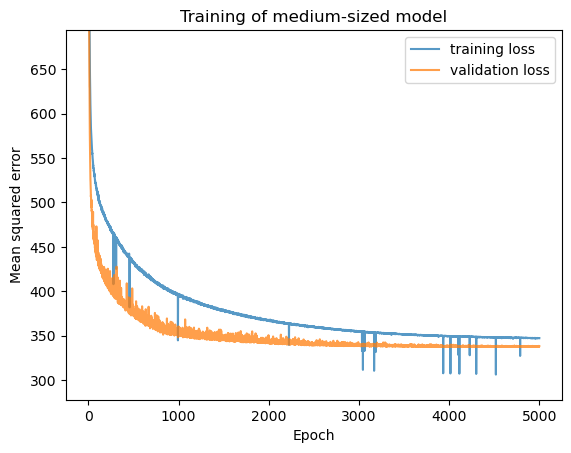

In [38]:
plt.plot(train_stats_76["train_loss"], label="training loss", alpha=0.75)
plt.plot(train_stats_76["valid_loss"], label="validation loss", alpha=0.75)
plt.legend()
plt.ylim([train_stats_76["train_loss"][-1] * 0.8,
          train_stats_76["train_loss"][-1] * 2])
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.title("Training of medium-sized model")

#### Training default model without dropout

In [46]:
model = simple_MLP(14, 160)
print(model)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

simple_MLP(
  (linear1): Linear(in_features=14, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=1, bias=True)
)
Number of trainable parameters in the model: 54081


In [47]:
batch_size = 1000
n_epochs = 10_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 5000)

optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats_160 = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [42:36<00:00,  3.91it/s, epoch=10000/10000, train_loss=1.089e+02, valid_loss=3.118e+02, learn_rate=1.000e-05]


In [48]:
print("Minimum of validation loss: {:.2f}".format(
    np.min(train_stats_160["valid_loss"])
))

Minimum of validation loss: 292.53


# Training with dropout regularization

In [39]:
class regularized_MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.device = torch.device("cuda")
        self.linear1 = nn.Linear(input_size, hidden_size, device=self.device)
        self.linear2 = nn.Linear(hidden_size, hidden_size, device=self.device)
        self.linear3 = nn.Linear(hidden_size, hidden_size, device=self.device)
        self.linear4 = nn.Linear(hidden_size, 1, device=self.device)

        # drops elements before passing outputs from first hidden layer
        # to second hidden layer
        self.dropout1 = nn.Dropout(p=0.2)
        # drops elements before passing outputs from second hidden layer
        # to third hidden layer
        self.dropout2 = nn.Dropout(p=0.2)
        
    
    def forward(self, x):
        x = x.to(self.device)
        x = F.elu(self.linear1(x))
        x = self.dropout1(x)
        x = F.elu(self.linear2(x))
        x = self.dropout2(x)
        x = F.elu(self.linear3(x))
        x = F.elu(self.linear4(x))
        
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = '../models'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

#### Training default-sized model with dropout

In [40]:
model = regularized_MLP(14, 160)
print(model)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

regularized_MLP(
  (linear1): Linear(in_features=14, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)
Number of trainable parameters in the model: 54081


In [41]:
batch_size = 1000
n_epochs = 15_000

base_learning_rate = 1e-2
gamma = calc_gammar(0.1, 5000)

optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats_160_dropout = train(batch_size, n_epochs, optimizer, scheduler)

100%|████████████████████████████████████████████████████████████████████████████████| 15000/15000 [1:08:24<00:00,  3.65it/s, epoch=15000/15000, train_loss=3.802e+02, valid_loss=3.402e+02, learn_rate=1.000e-05]


Text(0.5, 1.0, 'Training of default-sized model with dropout')

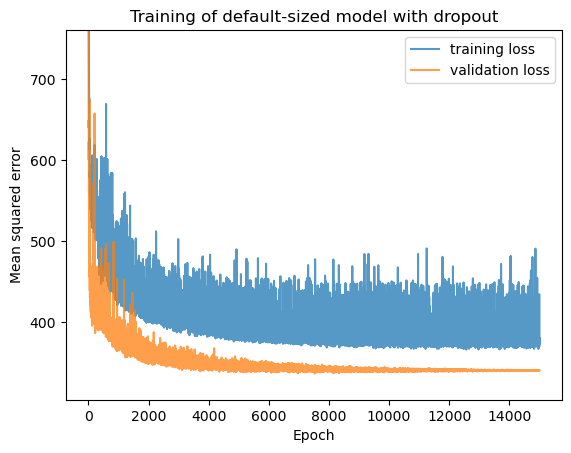

In [42]:
plt.plot(train_stats_160_dropout["train_loss"], label="training loss", alpha=0.75)
plt.plot(train_stats_160_dropout["valid_loss"], label="validation loss", alpha=0.75)
plt.legend()
plt.ylim([train_stats_160_dropout["train_loss"][-1] * 0.8,
          train_stats_160_dropout["train_loss"][-1] * 2])
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.title("Training of default-sized model with dropout")

#### Training large model with dropout

In [43]:
model = regularized_MLP(14, 324)
print(model)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

regularized_MLP(
  (linear1): Linear(in_features=14, out_features=324, bias=True)
  (linear2): Linear(in_features=324, out_features=324, bias=True)
  (linear3): Linear(in_features=324, out_features=324, bias=True)
  (linear4): Linear(in_features=324, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)
Number of trainable parameters in the model: 215785


In [44]:
batch_size = 1000
n_epochs = 15_000

base_learning_rate = 1e-2
gamma = calc_gammar(0.1, 5000)

optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats_324_dropout = train(batch_size, n_epochs, optimizer, scheduler)

100%|████████████████████████████████████████████████████████████████████████████████| 15000/15000 [1:18:36<00:00,  3.18it/s, epoch=15000/15000, train_loss=2.919e+02, valid_loss=2.837e+02, learn_rate=1.000e-05]


Text(0.5, 1.0, 'Training of large model with dropout')

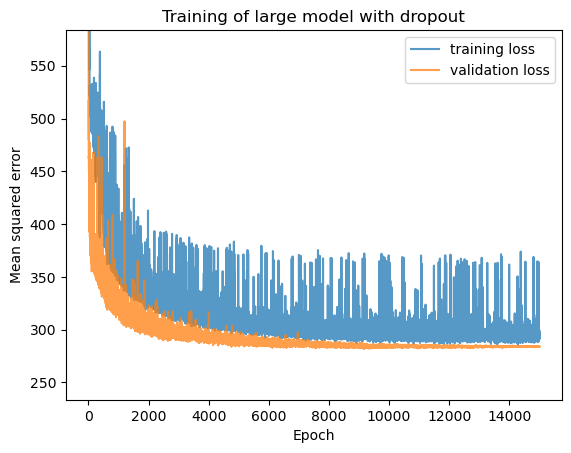

In [45]:
plt.plot(train_stats_324_dropout["train_loss"], label="training loss", alpha=0.75)
plt.plot(train_stats_324_dropout["valid_loss"], label="validation loss", alpha=0.75)
plt.legend()
plt.ylim([train_stats_324_dropout["train_loss"][-1] * 0.8,
          train_stats_324_dropout["train_loss"][-1] * 2])
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.title("Training of large model with dropout")